In [2]:
# GENERAL
import numpy as np
import scipy.stats as stats

# if one want interactive plotting zoom/tools :
%matplotlib notebook 
# inline non-interactive plots:
# %matplotlib inline

import matplotlib.pyplot as plt
plt.rcParams['figure.figsize']= [7.,5.] #set size of plots
import matplotlib as mpl


# LISA
from LISAhdf5 import LISAhdf5,ParsUnits
import tdi
import LISAParameters as LP

# PERSO
import Tools
import Tools.module_plot as myplot
import Tools.utils as utils
import Tools.normalized_L1_minimization as normL1min
import Tools.reweighting as weight
import Tools.blocktree as blocktree

# import importlib
# importlib.reload(myplot)

# Reference Signal

In [28]:
# folder that contains the data
myfolder = "/local/home/ablelly/GalacticBinaries_V0/LDC_1-3/" #
# noisy input file name
myfile_REF = "LDC1-3_VGB_v2.hdf5" #"monoVGB_f2_beta0_FD_noiseless.hdf5" #"GB_mono_source_FD_noiseless.hdf5" #"LDC1-3_VGB_v2.hdf5" # #"LDC1-3_VGB_v2_FD_noiseless.hdf5" #_FD_noiseless #"GB_mono_source_FD_noiseless.hdf5"
#non-noisy input file name
myfile_NonNoisy = "LDC1-3_VGB_v2_FD_noiseless.hdf5"

do_plot = 1 # display plots

<IPython.core.display.Javascript object>


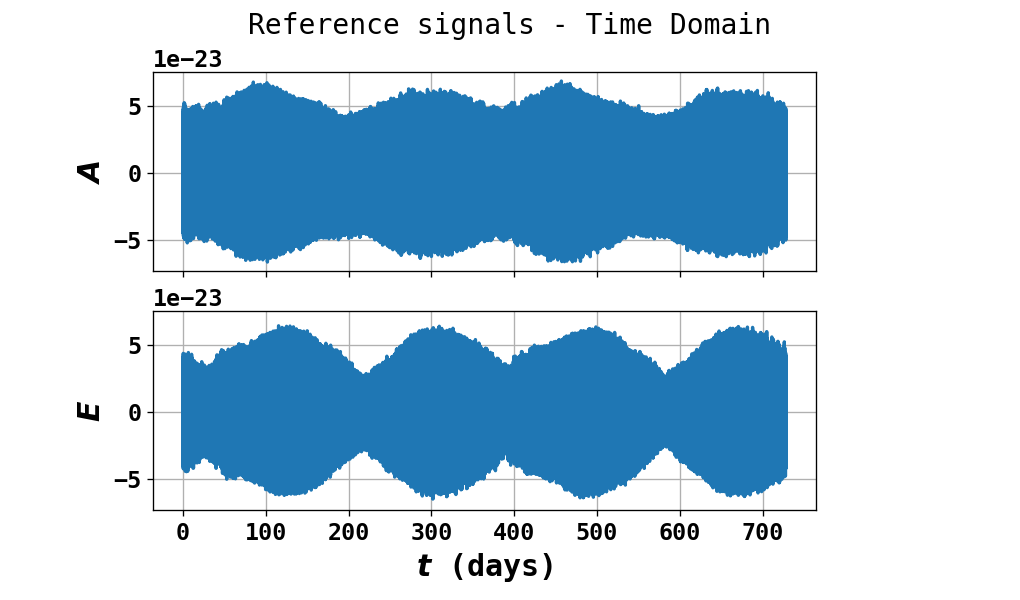

<IPython.core.display.Javascript object>


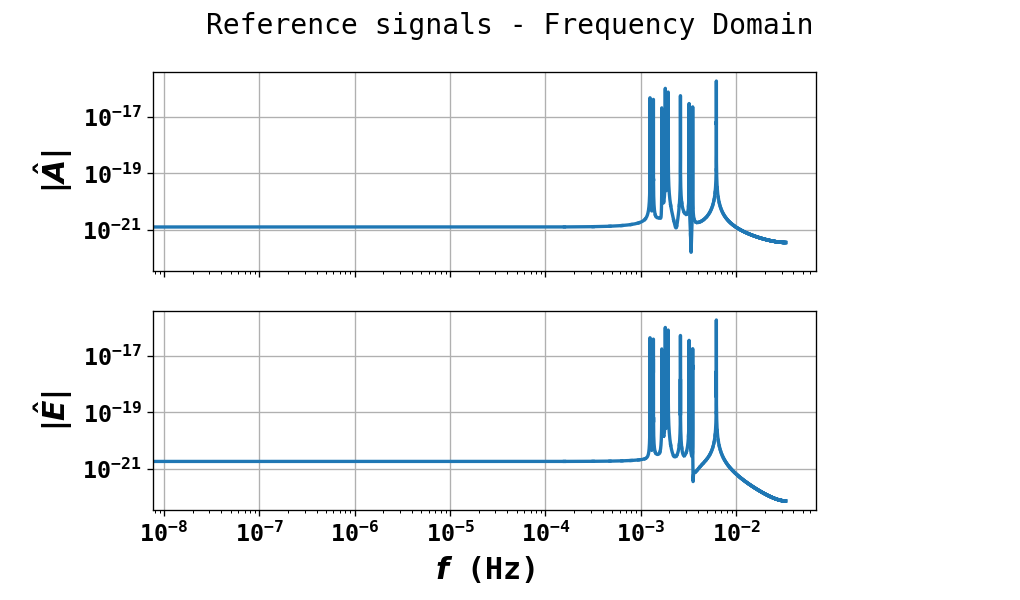

In [29]:
#reference data (without noise)
FD5 =  LISAhdf5(myfolder+myfile_NonNoisy)
GWs = FD5.getSourcesName()
p = FD5.getSourceParameters(GWs[0])
td = FD5.getPreProcessTDI()
del_t = float(p.get("Cadence"))
Tobs = float(p.get("ObservationDuration"))

picDir_loc = '/local/home/ablelly/GalacticBinaries_V0/Data/pictures/'
save_loc = 0

tm = td[:, 0]
Npts = len(tm)
Xt0 = td[:, 1]
Yt0 = td[:, 2]
Zt0 = td[:, 3]

At0 = (Zt0 - Xt0)/np.sqrt(2.0)
Et0 = (Zt0 - 2.0*Yt0 + Xt0)/np.sqrt(6.0)
Adf0 = np.fft.rfft(At0) * del_t
Edf0 = np.fft.rfft(Et0) * del_t
freqD = np.fft.rfftfreq(len(tm), del_t)
Nf = freqD.shape[0]

yt0_noNoise = np.concatenate((At0.reshape((Npts,1)),Et0.reshape((Npts,1))), axis=1)
yf0_noNoise = np.concatenate((Adf0.reshape((Nf,1)),Edf0.reshape((Nf,1))), axis=1)

myplot.plot_time(tm, At0, Et0, title="Reference signals - Time Domain")
fig,ax=myplot.plot_freq(freqD, Adf0, Edf0,title="Reference signals - Frequency Domain")

/local/home/ablelly/.local/lib/python3.6/site-packages/LISAhdf5.py:508: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  params.addPar(ky,p.value,Str(p.attrs['Units']))
/local/home/ablelly/.local/lib/python3.6/site-packages/LISAhdf5.py:741: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  d = np.copy(self.h5file['H5LISA/PreProcess/TDIdata'].value)


<IPython.core.display.Javascript object>


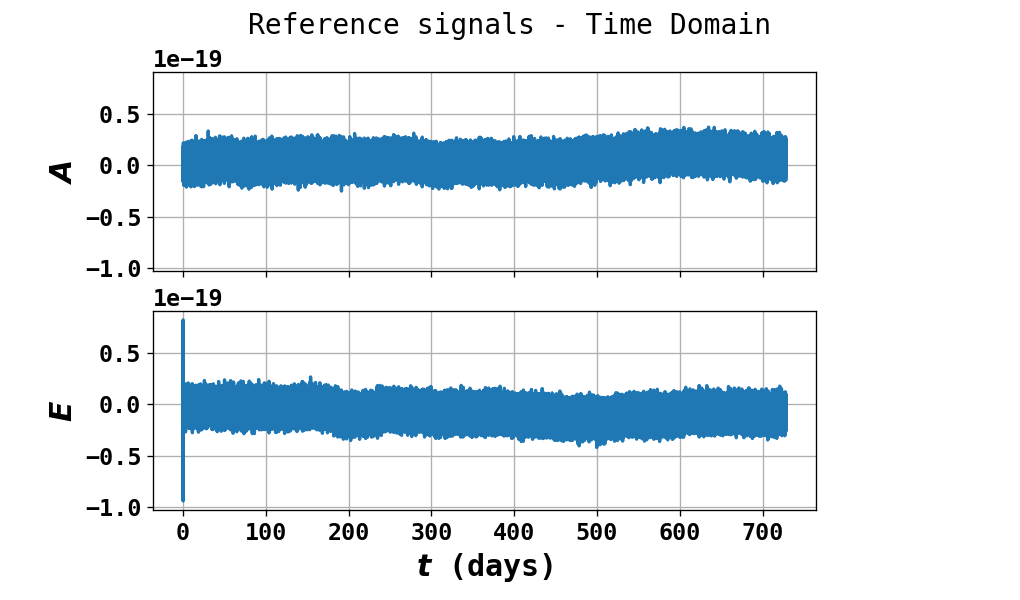

<IPython.core.display.Javascript object>


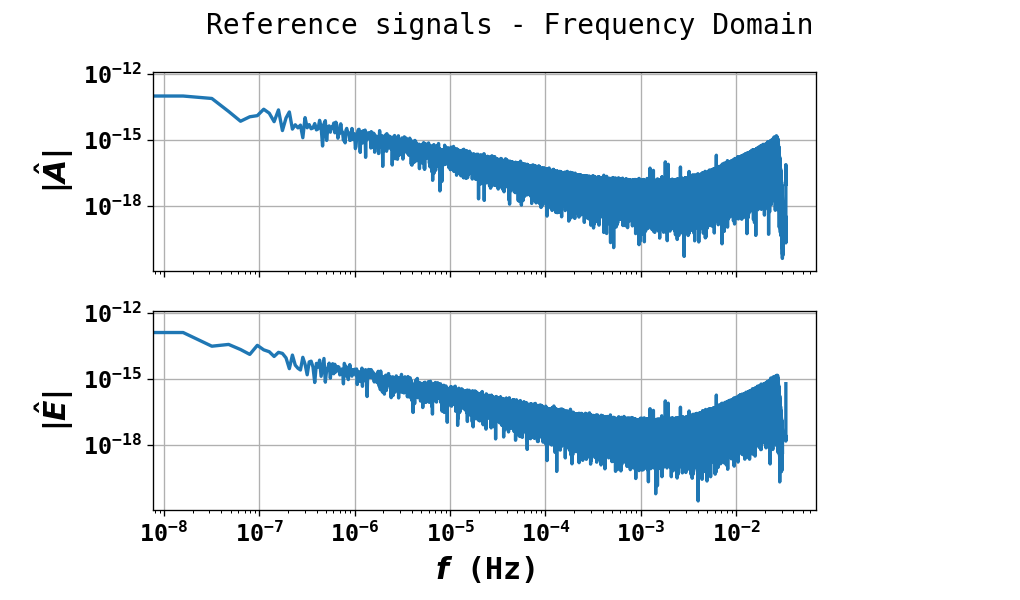

In [4]:
#Noisy data
FD5 =  LISAhdf5(myfolder+myfile_REF)
GWs = FD5.getSourcesName()
p = FD5.getSourceParameters(GWs[0])
td = FD5.getPreProcessTDI()
del_t = float(p.get("Cadence"))
Tobs = float(p.get("ObservationDuration"))

picDir_loc = '/local/home/ablelly/GalacticBinaries_V0/Data/pictures/'
save_loc = 0

tm = td[:, 0]
Npts = len(tm)
Xt0 = td[:, 1]
Yt0 = td[:, 2]
Zt0 = td[:, 3]

At0 = (Zt0 - Xt0)/np.sqrt(2.0)
Et0 = (Zt0 - 2.0*Yt0 + Xt0)/np.sqrt(6.0)
Adf0 = np.fft.rfft(At0) * del_t
Edf0 = np.fft.rfft(Et0) * del_t
freqD = np.fft.rfftfreq(len(tm), del_t)
Nf = freqD.shape[0]

yt0 = np.concatenate((At0.reshape((Npts,1)),Et0.reshape((Npts,1))), axis=1)
yf0 = np.concatenate((Adf0.reshape((Nf,1)),Edf0.reshape((Nf,1))), axis=1)


myplot.plot_time(tm, At0, Et0, title="Reference signals - Time Domain")
fig,ax=myplot.plot_freq(freqD, Adf0, Edf0,title="Reference signals - Frequency Domain")


# LISA Gaussian Noise

In [23]:
noiseModel = 'SciRDv1'
PSD_A = Npts*np.sqrt(del_t)*tdi.noisepsd_AE(freqD, model=noiseModel, includewd=None) #del_t*
PSD_E = Npts*np.sqrt(del_t)*tdi.noisepsd_AE(freqD, model=noiseModel, includewd=None)
PSD_A[0] = 100.*PSD_A[1] #otherwise, Nan
PSD_E[0] = 100.*PSD_E[1] #otherwise, Nan

Nf = len(freqD)

N_A = np.sqrt(PSD_A)*(np.random.randn(Nf) + 1.j*np.random.randn(Nf))
N_E = np.sqrt(PSD_E)*(np.random.randn(Nf) + 1.j*np.random.randn(Nf))

# Normalize Noisy data

<IPython.core.display.Javascript object>


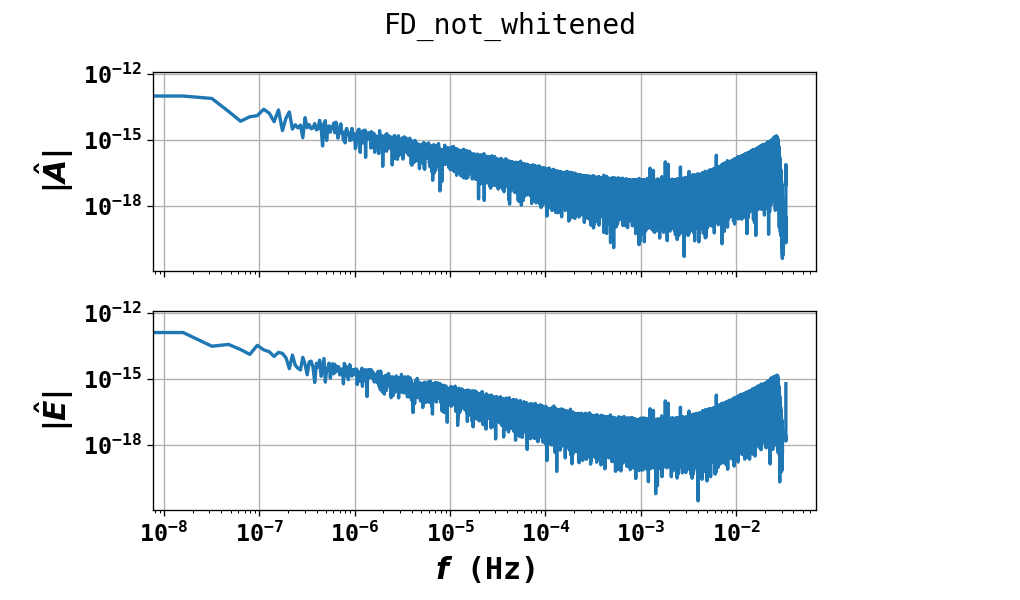

<IPython.core.display.Javascript object>


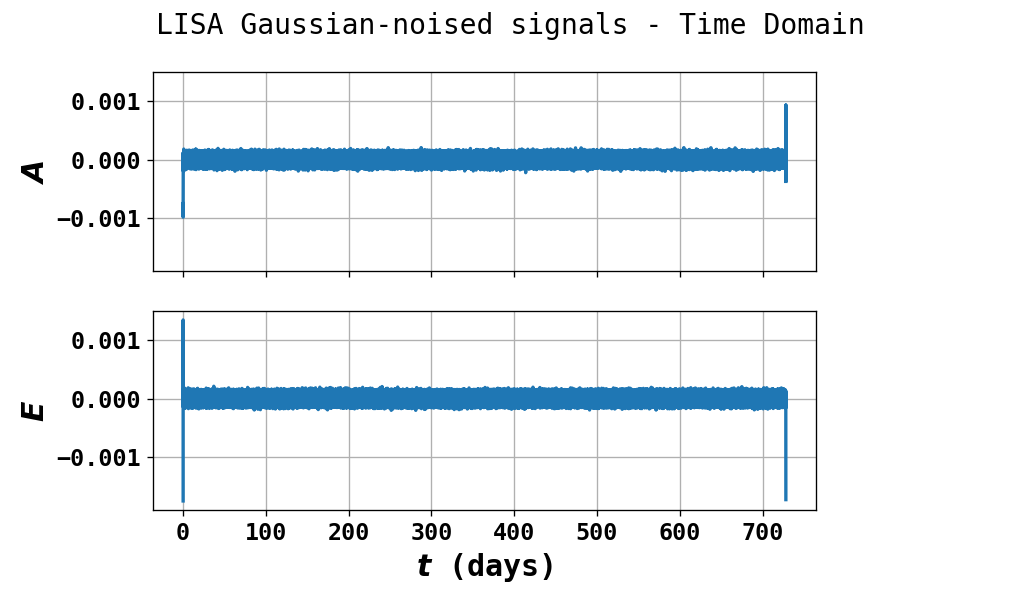

<IPython.core.display.Javascript object>


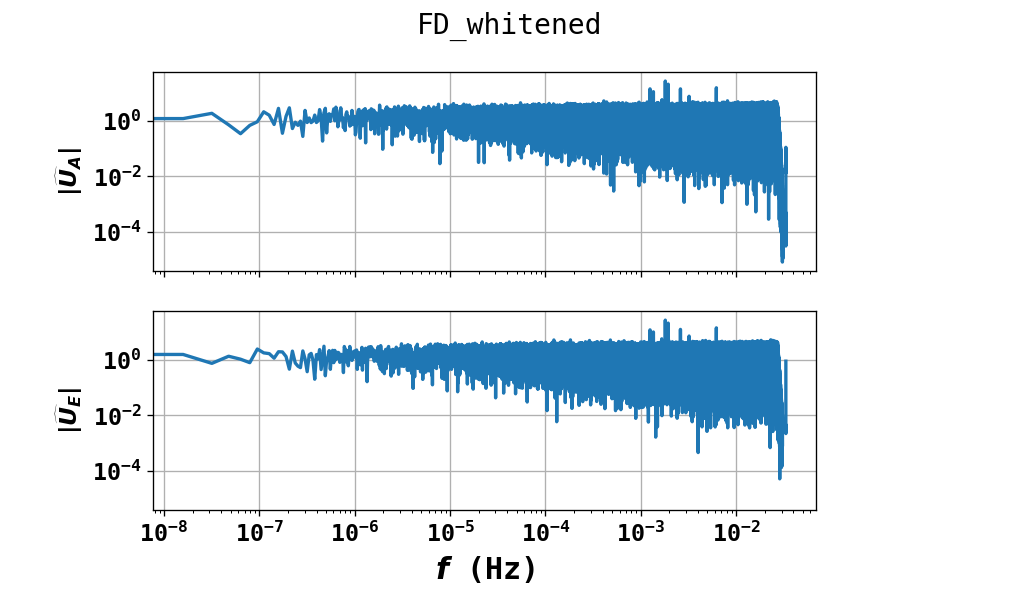

In [24]:

A = 1. # amplitude multiplier
do_sig_corr = 1 #only for LDC data: PSD correction
do_add_noise = 0 #if input is non-noisy data


if do_add_noise:
    Adf = A*Adf0 + N_A
    Edf = A*Edf0 + N_E
else:
    Adf = A*Adf0
    Edf = A*Edf0

yAf = Adf 
yEf = Edf 

    
y_f = np.concatenate((yAf.reshape((Nf,1)),yEf.reshape((Nf,1))),axis=1)

yAt = np.fft.irfft(yAf/del_t, Npts)
yEt = np.fft.irfft(yEf/del_t, Npts)
y_t = np.concatenate((yAt.reshape((Npts,1)),yEt.reshape((Npts,1))),axis=1)


myplot.plot_freq(freqD, yAf, yEf,
                     title="FD_not_whitened", 
                     save=save_loc, picDir=picDir_loc)


if do_sig_corr: 
    data_sig = np.load('stdDev_polApprox_order4_allCoeffs.npz')
    mycoeffs = data_sig['coeffs']
    poly_sig = np.poly1d(mycoeffs)
# normalization :
    sig = poly_sig(freqD)
    yAf = yAf / (np.sqrt(PSD_A)*sig)
    yEf = yEf / (np.sqrt(PSD_E)*sig)
else:
    yAf = yAf / np.sqrt(PSD_A)
    yEf = yEf / np.sqrt(PSD_E)

y_f = np.concatenate((yAf.reshape((Nf,1)),yEf.reshape((Nf,1))),axis=1)

yAt = np.fft.irfft(yAf/del_t, Npts)
yEt = np.fft.irfft(yEf/del_t, Npts)
y_t = np.concatenate((yAt.reshape((Npts,1)),yEt.reshape((Npts,1))),axis=1)
    
    

myplot.plot_time(tm, yAt, yEt, 
                 title="LISA Gaussian-noised signals - Time Domain")
myplot.plot_freq(freqD, yAf, yEf,
#                      title="LISA Gaussian-noised signals - Frequency Domain - no H", 
                 title="FD_whitened", 
                 ylabel=[r'$|\widehat{U}_A|$',r'$|\widehat{U}_E|$'])
    


# Block Decomposition

max index :  1698693


<IPython.core.display.Javascript object>


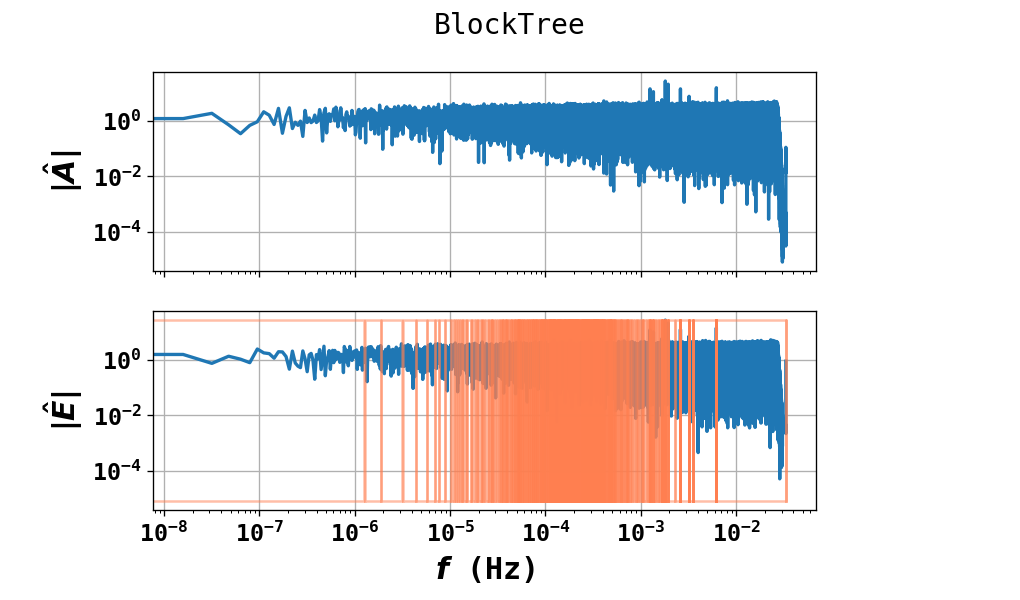

In [34]:
do_blockTree = 1
p_tree = 0.999999 # rho =1. - p_tree
minBlockSize = 10
# parameters for a law of standard chi^2_4
myfactor = 4 
myscale = 1. 


if do_blockTree:
    if do_sig_corr: #correction only reasonnable for frequencies f<0.027Hz
        ind = (freqD<0.027) 
    else:
        ind = (freqD>=0.)
        
    nonzero_ind = np.where(ind)[0]
    print('max index : ',nonzero_ind[-1])
    y_tree = 0.*np.copy(y_f)
    y_tree[ind,:] = y_f[ind,:]
    

    mytree_init = blocktree.makeTree_BottomUp_init(minBlockSize,Nf,y_tree,p_tree, factor=myfactor, scale=myscale)
    
    tree_unif = np.copy(mytree_init)
    
    mytree = blocktree.makeTree_BottomUp(y_tree, mytree_init, p_tree, minBlockSize, Rcomp=5., factor=myfactor, scale=myscale)
    
    
    id_blocks = mytree[:,:3]

    myplot.plot_freq_blocktree(freqD, y_f[:,0], y_f[:,1], id_blocks,
#                        xlim=[1.e-3,1.e-2], ylim=[1.e-1,2.e1],
                       title='BlockTree', ylabel=None)#
    active_index = np.full(freqD.shape, False)
    for i in range(mytree.shape[0]):
        if mytree[i,-2]:
            active_index[mytree[i,0]:mytree[i,1]+1] = np.full(mytree[i,2],True)
    
else:
    id_blocks = utils.create_regular_blocks(minBlockSize,Nf)

[0 79 80 443.9301476189442 454.95082046213736 False 8]


# L1 Minimization - Standard Resolution

eps_cvg =  1e-05
+++++ ITER  0
Reweighting
+++++ ITER  1
Reweighting
+++++ ITER  2
Reweighting
+++++ ITER  3
Reweighting
+++++ ITER  4
Reweighting
+++++ ITER  5
Reweighting
+++++ ITER  6
Reweighting
+++++ ITER  7
Reweighting
END


<IPython.core.display.Javascript object>


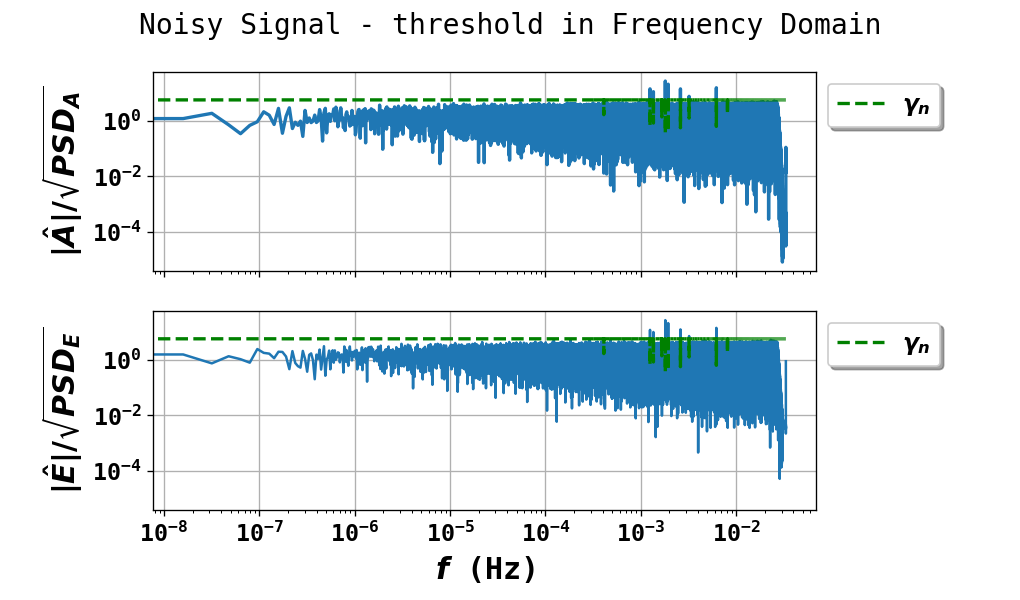

<IPython.core.display.Javascript object>


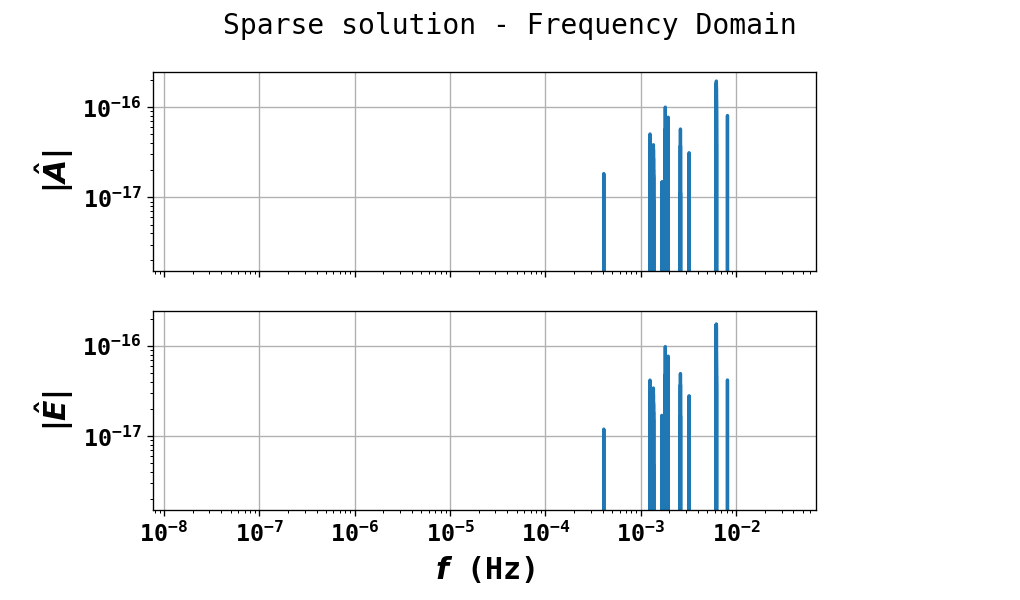

<IPython.core.display.Javascript object>


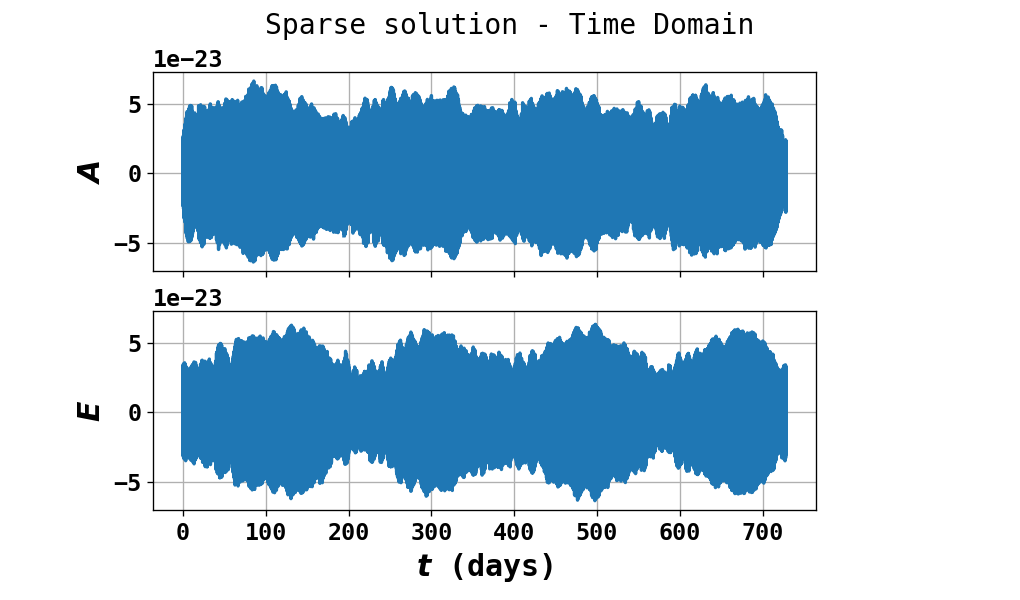

NMSE =  11.117223038080478


In [36]:
# gaussian Noise
p_l1 = 0.999999
x0 = utils.find_threshold_chi2(4,p_l1) #Chi2_4[prob] #43.311 #x0=Chi2[prob]
do_plot = 1
sigma_norm = 1. # noise 
epsilon_cvg = sigma_norm*1.e-5 # convergence parameter for FBS algo
epsilon_gamma = 0.1*sigma_norm  #convervence parameter for reweighted L1 minimization
print('eps_cvg = ',epsilon_cvg)
coeff_weights = 3. #coefficient for reweighting



x_k = 0.*y_f #y
x_kt = 0.*y_t
Lmax = 15 #5 #1
Kmax = 60


gamma_0 = np.sqrt(x0)*np.ones(freqD.shape)
gamma_n = gamma_0


### REWEIGHTED L1 minimization
l = 0
delta_gamma = 1.

while ((l < Lmax) and delta_gamma > epsilon_gamma):
    print('+++++ ITER ',l)
    x_k = normL1min.prox_f(y_f, gamma_n,alpha=1.)

    gamma_nm1 = gamma_n

    print('Reweighting')
    gamma_n = weight.compute_weights(x_k, gamma_0,coeff=coeff_weights)
    
    delta_gamma = np.amax(np.abs(gamma_n-gamma_nm1))
    l+=1
    

if do_sig_corr:
    Adf_sparse = np.sqrt(PSD_A)*sig*x_k[:,0]
    Edf_sparse = np.sqrt(PSD_E)*sig*x_k[:,1]
else:
    Adf_sparse = np.sqrt(PSD_A)*x_k[:,0]
    Edf_sparse = np.sqrt(PSD_E)*x_k[:,1]


At_sparse = np.fft.irfft(Adf_sparse / del_t, Npts)
Et_sparse = np.fft.irfft(Edf_sparse / del_t, Npts)
yt = np.concatenate((At_sparse.reshape((Npts,1)),Et_sparse.reshape((Npts,1))),axis=1)
print('END')
if do_plot:
    myplot.plot_freq_filter(freqD, y_f[:,0], y_f[:,1], gamma_n, 
                title='Noisy Signal - threshold in Frequency Domain', ylabel=[r'$|\hat{A}|/\sqrt{PSD_A}$',r'$|\hat{E}|/\sqrt{PSD_E}$'])
    myplot.plot_freq(freqD, Adf_sparse, Edf_sparse, 
                     title="Sparse solution - Frequency Domain")
    myplot.plot_time(tm, At_sparse, Et_sparse,
                     title = "Sparse solution - Time Domain")

print('NMSE = ', utils.compute_logError(A*yt0_noNoise,yt))

In [22]:
np.argmax(np.abs(Adf_sparse))
print((np.abs(y_f[0,0])**2+np.abs(y_f[0,1])**2), gamma_0[0])

52.556095448400185 5.777269388011856


# BlockTree + Unstructured sparsity

eps_cvg =  1e-05
[TEST]  P(|U_0|^2/PSD > x0) =  0.4113872473777545
+++++ ITER  0
+++++ ITER  1
+++++ ITER  2
+++++ ITER  3
+++++ ITER  4
+++++ ITER  5
+++++ ITER  6
END


<IPython.core.display.Javascript object>


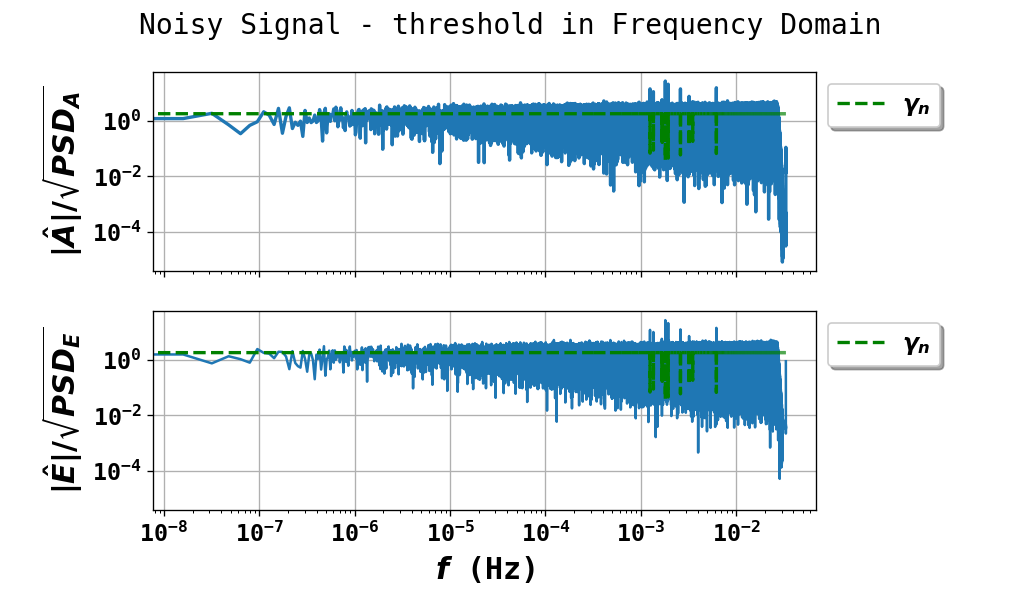

<IPython.core.display.Javascript object>


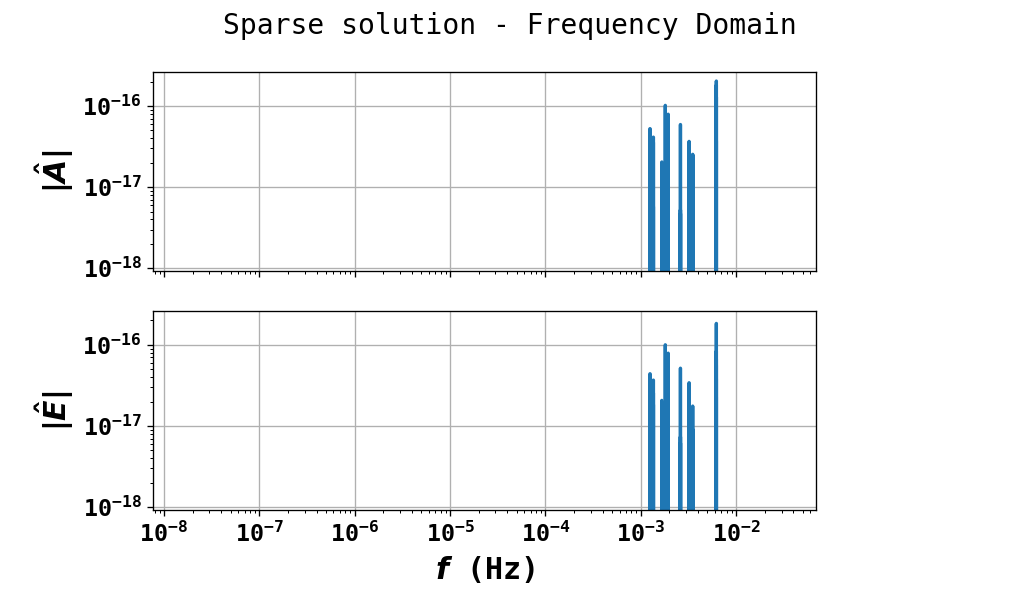

<IPython.core.display.Javascript object>


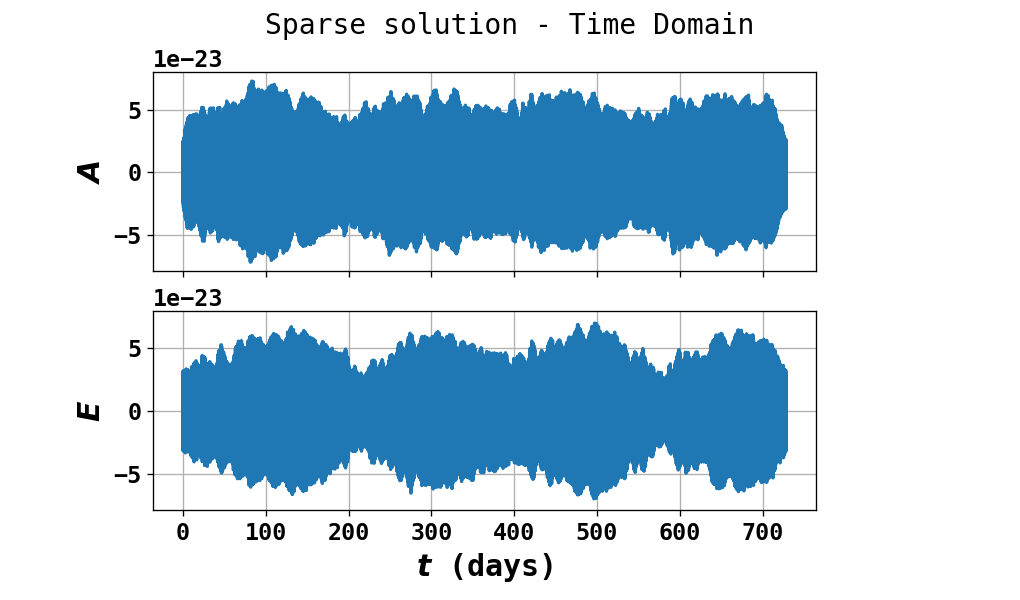

NMSE =  12.850702772691694


In [37]:
# gaussian Noise
p_l1 = 0.5
x0 = utils.find_threshold_chi2(4,p_l1) #Chi2_4[prob] #43.311 #x0=Chi2[prob]
do_plot = 1

sigma_norm = 1. # noise 
epsilon_cvg = sigma_norm*1.e-5 # convergence parameter for FBS algo
epsilon_gamma = 0.1*sigma_norm  #convervence parameter for reweighted L1 minimization
print('eps_cvg = ',epsilon_cvg)
coeff_weights = 3. #coefficient for reweighting



x_k = 0.*y_f #y
x_kt = 0.*y_t
Lmax = 15 #15 #5 #1
Kmax = 60


gamma_0 = np.sqrt(x0)*np.ones(freqD.shape)
print('[TEST]  P(|U_0|^2/PSD > x0) = ',(np.sum(np.abs(y_f[:,0])**2 + np.abs(y_f[:,1])**2 > gamma_0**2))/Nf)

gamma_n = gamma_0


### REWEIGHTED L1 minimization
l = 0
delta_gamma = 1.

while ((l < Lmax) and delta_gamma > epsilon_gamma):
    print('+++++ ITER ',l)
    x_k_tmp = normL1min.prox_f(y_f[active_index,:], gamma_n[active_index],alpha=1.)
    x_k[active_index,:] = np.copy(x_k_tmp)
    
    gamma_nm1 = gamma_n

        
    gamma_n = weight.compute_weights(x_k, gamma_0,coeff=coeff_weights)
    
    delta_gamma = np.amax(np.abs(gamma_n-gamma_nm1))
    l+=1


if do_sig_corr:
    Adf_sparse = np.sqrt(PSD_A)*x_k[:,0]*sig
    Edf_sparse = np.sqrt(PSD_E)*x_k[:,1]*sig
else:
    Adf_sparse = np.sqrt(PSD_A)*x_k[:,0]
    Edf_sparse = np.sqrt(PSD_E)*x_k[:,1]


At_sparse = np.fft.irfft(Adf_sparse / del_t, Npts)
Et_sparse = np.fft.irfft(Edf_sparse / del_t, Npts)
yt = np.concatenate((At_sparse.reshape((Npts,1)),Et_sparse.reshape((Npts,1))),axis=1)
print('END')
if do_plot:
    myplot.plot_freq_filter(freqD, y_f[:,0], y_f[:,1], gamma_n, 
                title='Noisy Signal - threshold in Frequency Domain', ylabel=[r'$|\hat{A}|/\sqrt{PSD_A}$',r'$|\hat{E}|/\sqrt{PSD_E}$'])
    myplot.plot_freq(freqD, Adf_sparse, Edf_sparse, 
                     title="Sparse solution - Frequency Domain")
    myplot.plot_time(tm, At_sparse, Et_sparse,
                     title = "Sparse solution - Time Domain")

print('NMSE = ', utils.compute_logError(A*yt0_noNoise,yt))